## Imports

In [5]:
import sympy as smp
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import datetime
from scipy.integrate import quad, solve_ivp
from tqdm import tqdm
from scipy.optimize import curve_fit
from numba import njit, complex128, float64, int64, prange
from scipy.special import factorial, logsumexp, gammaln
import json
from scipy.interpolate import interp1d
import pandas as pd
import ast
import tempfile
import shutil
import math
from multiprocessing import Pool, Process, Lock
import matplotlib.cm as cm


## Functions

In [6]:
# Parameters
hbar = 1.0   # in natural units
epsilon = 1e-8

def g(t, tau, t_max):
    return (t_max-t)/tau if tau > 0 else t_max

def H(t, tau, t_max, k):
    g_f = g(t, tau, t_max)
    return np.array([[g_f - np.cos(k), np.sin(k)], [np.sin(k), -(g_f - np.cos(k))]])

def psi_dt(t, psi,  tau, t_max, k):
    return -1j * np.dot(H(t, tau, t_max, k), psi)

def rho_dt(t, rho, tau, t_max, k, w):
    h = H(t, tau, t_max, k)
    z = np.array([[1, 0], [0, -1]])
    # convert rho from vector to matrix
    rho = rho.reshape((2,2))
    return (-1j * (np.dot(h, rho) - np.dot(rho, h)) + w**2 * (np.dot(z, np.dot(rho,z)) - rho)).flatten()

def lz_time_evolution_single_k(k, t_max, tau):
    # use scipy.integrate.solve_ivp to solve the ODE H(t) psi(t) = i hbar d/dt psi(t)
    psi0 = np.array([0+0j, 1+0j])
    return  solve_ivp(fun=psi_dt, method='DOP853', t_span=(0, t_max), y0=psi0, args=(tau, t_max, k), rtol = epsilon, atol = epsilon)

def noisy_lz_time_evolution_single_k(k, t_max, tau, w):
    # use scipy.integrate.solve_ivp to solve the ODE H(t) psi(t) = i hbar d/dt psi(t)
    rho0 = np.array([[0+0j, 0+0j], [0+0j, 1+0j]])
    return  solve_ivp(fun=rho_dt, method='DOP853', t_span=(0, t_max), y0=rho0.flatten(), args=(tau, t_max, k, w), rtol = epsilon, atol = epsilon)


def lz_time_evolution(ks, tau):
    t_max = 100*tau
    # use pool to parallelize the calculation for each k
    with Pool() as pool:
        results = pool.starmap(lz_time_evolution_single_k, [(k, t_max, tau) for k in ks])
    return results

def noisy_lz_time_evolution(ks, tau, w):
    t_max = 100*tau
    # use pool to parallelize the calculation for each k
    with Pool() as pool:
        results = pool.starmap(noisy_lz_time_evolution_single_k, [(k, t_max, tau, w) for k in ks])
    return results


def calc_pk(ks, tau):
    # calculate the time evolution for each k
    results = lz_time_evolution(ks, tau)
    # calculate the probabilities for each k
    pks = np.array([np.abs(np.dot(np.array([np.sin(k/2), np.cos(k/2)]), result.y[:,-1]/np.linalg.norm(result.y[:,-1])))**2 for k ,result in zip(ks, results)])
    # remove valuse that are too small
    return  np.where(pks < epsilon/100, 0, pks)

def calk_noisy_pk(ks, tau, w):
    # calculate the time evolution for each k
    results = noisy_lz_time_evolution(ks, tau, w)
    # calculate the probabilities for each k
    pks = np.array([np.abs(np.dot(np.array([np.sin(k/2), np.cos(k/2)]), np.dot(result.y[:,-1].reshape(2,2), np.array([[np.sin(k/2)], [np.cos(k/2)]])))) for k ,result in zip(ks, results)])
    # remove valuse that are too small
    return  np.where(pks < epsilon/100, 0, pks)
     

def k_f(n, N):
    return np.pi * (2 * n + 1) / N

def p_k_analytic(tau, k):
    return np.exp(-2*np.pi*tau*(k**2))*(np.cos(k/2)**2)

def ln_P_tilda_func(theta, pks):
    return np.sum(np.log(1 + pks * (np.exp(1j * theta * 2) - 1)))

def integrand_func(theta, pks, d):
    return np.exp(ln_P_tilda_func(theta, pks) - 1j * theta * d)

def P_func(pks, d):
    integral, _ = quad(lambda theta: np.real(integrand_func(theta, pks, d)), -np.pi, np.pi, limit=10000)
    return np.abs(integral / (2 * np.pi))

def D_func(P_vals):
    N = (len(P_vals) - 1)*2
    ns = np.arange(0,N + 1,2)
    return (1 / N) * np.sum(ns * P_vals)

def beta(d):
    if d == 0:
        return np.inf
    elif d > 0.5:
        return np.nan
    else:
        return -0.5 * (np.log(d) - np.log(1 - d))

def thermal_prob(mean, N):
    beta_val = beta(mean)
    if np.isnan(beta_val):
        return np.nan
    if beta_val == np.inf:
        probabilities = np.zeros(N//2 + 1)
        probabilities[0] = 1
        return probabilities

    # Generate the range of n values
    n_values = np.arange(0, N+1, 2)

    # Compute log-probabilities
    log_unnorm_probs = (-2 * n_values * beta_val) - gammaln(n_values + 1) - gammaln(N - n_values + 1)
    
    # Normalize using logsumexp to avoid overflow/underflow
    log_norm = logsumexp(log_unnorm_probs)
    normalized_logprobs = log_unnorm_probs - log_norm
    
    # Exponentiate to get probabilities
    probabilities = np.exp(normalized_logprobs)

    return probabilities

def calculate_cumulants(probability_mass_function, values):
    # Calculate the moments
    mean = np.sum(probability_mass_function * values)
    second_moment = np.sum(probability_mass_function * values ** 2)
    third_moment = np.sum(probability_mass_function * values ** 3)
    fourth_moment = np.sum(probability_mass_function * values ** 4)

    # Calculate the cumulants using the moments
    variance = second_moment - mean ** 2
    skewness = (third_moment - 3 * mean * second_moment + 2 * mean ** 3)
    kurtosis = (fourth_moment - 4 * mean * third_moment + 6 * mean ** 2 * second_moment - 3 * mean ** 4)

    cumulants = {'mean': mean, 'second_moment': second_moment, 'third_moment': third_moment, 'fourth_moment': fourth_moment, 'variance': variance, 'skewness': skewness, 'kurtosis': kurtosis}
    return cumulants

def calc_kink_probabilities(pks, d_vals):
    with Pool() as pool:
        return np.array(pool.starmap(P_func, [(pks, d) for d in d_vals]))
    


def calc_data(Ns, taus):
    processes = []
    lock = Lock()
    for N, tau in [(N, tau) for N in Ns for tau in taus]:
        p = Process(target=calc_data_single, args=(N, tau, lock))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        

def calc_data_single(N, tau, lock):
    os.nice(1)
    tau = round(tau, 6)

    # Load data from file if it exists, or create an empty DataFrame
    try:
        df = pd.read_csv('data.csv')
        df = df.sort_values(['N', 'tau'])
    except FileNotFoundError:
        df = pd.DataFrame(columns=['N', 'tau', 'type', 'probability', 'mean', 
                                'second_moment', 'third_moment', 'fourth_moment',
                                'variance', 'skewness', 'kurtosis'])

    # Check if data[N][tau] is in DataFrame
    if not df.empty and not df[(df['N'] == N) & (df['tau'] == tau)].empty:
        pass


    # Calculate and save to file
    else:
        # Calculate probabilities
        ks = k_f(np.arange(0, N/2), N)
        pks_analytic = p_k_analytic(tau, ks)
        pks_numric = calc_pk(ks, tau)
        d_vals = np.arange(0,N+1,2)
        
        num_probability_mass_function = calc_kink_probabilities(pks_numric, d_vals)
        num_probability_mass_function = np.where(num_probability_mass_function < epsilon, 0, num_probability_mass_function)
        num_mask = (np.roll(num_probability_mass_function, 0) == 0) & (np.roll(num_probability_mass_function, -2) == 0)
        num_mask[-1] = False
        num_mask[-2] = False
        num_probability_mass_function[np.roll(num_mask, 1)] = 0

        analytic_probability_mass_function = calc_kink_probabilities(pks_analytic, d_vals)
        analytic_probability_mass_function = np.where(analytic_probability_mass_function < epsilon, 0, analytic_probability_mass_function)
        analytic_mask = (np.roll(analytic_probability_mass_function, 0) == 0) & (np.roll(analytic_probability_mass_function, -2) == 0)
        analytic_mask[-1] = False
        analytic_mask[-2] = False
        analytic_probability_mass_function[np.roll(analytic_mask, 1)] = 0


        d_num = D_func(num_probability_mass_function)
        therm_probability_mass_function = thermal_prob(d_num, N)
        therm_probability_mass_function = np.where(therm_probability_mass_function < epsilon, 0, therm_probability_mass_function)
        therm_mask = (np.roll(therm_probability_mass_function, 0) == 0) & (np.roll(therm_probability_mass_function, -2) == 0)
        therm_mask[-1] = False
        therm_mask[-2] = False
        therm_probability_mass_function[np.roll(therm_mask, 1)] = 0

        # Calculate cumulants
        num_cumulants = calculate_cumulants(num_probability_mass_function, d_vals)
        analytic_cumulants = calculate_cumulants(analytic_probability_mass_function, d_vals)
        therm_cumulants = calculate_cumulants(therm_probability_mass_function, d_vals)

        # Prepare data for DataFrame
        pk_data_df = pd.DataFrame({'probability': [pks_numric.tolist()], 'N': [N], 'tau': [tau], 'type': ['pk']})
        num_data_df = pd.DataFrame({**num_cumulants, 'probability': [num_probability_mass_function.tolist()], 'N': [N], 'tau': [tau], 'type': ['numeric']})
        therm_data_df = pd.DataFrame({**therm_cumulants, 'probability': [therm_probability_mass_function.tolist()], 'N': [N], 'tau': [tau], 'type': ['thermal']})
        analytic_data_df = pd.DataFrame({**analytic_cumulants, 'probability': [analytic_probability_mass_function.tolist()], 'N': [N], 'tau': [tau], 'type': ['analytic']})

        
        with lock:
        # Load data from file if it exists, or create an empty DataFrame
            try:
                df = pd.read_csv('data.csv')
                df = df.sort_values(['N', 'tau'])
            except FileNotFoundError:
                df = pd.DataFrame(columns=['N', 'tau', 'type', 'probability', 'mean', 
                                        'second_moment', 'third_moment', 'fourth_moment',
                                        'variance', 'skewness', 'kurtosis'])
            # Concatenate the DataFrames
            df = pd.concat([df, pk_data_df, num_data_df, analytic_data_df, therm_data_df])
            df.to_csv('data.csv', index=False)


def plot_time_ev(psi_t, t_max):
    # Prepare a time array
    time_array = np.linspace(0,t_max, psi_t.shape[0])

    # Calculate the absolute squares of the components
    probabilities = np.abs(psi_t)**2

    # Plot the probabilities for each state as a function of time
    plt.figure(figsize=(10,6))
    plt.plot(time_array, probabilities[:,0], label="State 0")
    plt.plot(time_array, probabilities[:,1], label="State 1")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.title("Time evolution of a two-level system")
    plt.grid(True)
    plt.show()



def pk_analitic(k_values, tau):
    return np.array([np.exp(-np.pi*tau*(k)/2)*(np.cos(k/2)**2) for k in k_values])





def plot_cumulant21_ratio(Ns, tau_min, tau_max, save=False, log=True):
    plt.figure(figsize=(16, 9))

    colors = cm.rainbow(np.linspace(0, 1, len(Ns)*3))

    # Iterate over Ns
    for idx, N in enumerate(Ns):
        # Get the data in the tau range for the current N
        data = get_data_in_tau_range(N, tau_min, tau_max)
        
        # Split the data into numeric and thermal
        num_data = data[data['type'] == 'numeric']
        therm_data = data[data['type'] == 'thermal']
        analytic_data = data[data['type'] == 'analytic']

        # Calculate the ratio of the second cumulant to the first (variance/mean) for numeric and thermal data
        num_ratio = num_data['variance'] / num_data['mean']
        therm_ratio = therm_data['variance'] / therm_data['mean']
        analytic_ratio = analytic_data['variance'] / analytic_data['mean']

        # Plot both numeric and thermal data with different colors and labels
        
        plt.plot(therm_data['tau'], therm_ratio, color=colors[idx], label=f'Thermal N={N}', marker='s', linewidth=0.1, markersize=6)
        # plt.plot(analytic_data['tau'], analytic_ratio, color=colors[idx+1], label=f'Analytic N={N}', marker='o', linewidth=0.1, markersize=6)
        plt.plot(num_data['tau'], num_ratio, color=colors[idx+2], label=f'Numeric N={N}', marker='^', linewidth=0.1, markersize=6)

    # taus = np.logspace(-3, -2, 5)
    # plt.plot(taus, np.full(len(taus),0.5), label='Theoretical Variance/Mean = 0.5', color='black', linewidth=1)
    taus = np.logspace(1, 2, 5)
    plt.plot(taus, np.full(len(taus),((2-np.sqrt(2)))), label='Theoretical Numeric Variance/Mean = 2-2^0.5', color='black', linewidth=1)
    # taus = np.logspace(0.5, 1.5, 30)
    # plt.plot(taus, 1-1/(2*np.pi)*((2*taus)**(-0.5)), label='Theoretical Thermal Variance/Mean = 1-(1/2pi)*(2tau)^0.5', color='black', linewidth=1)
    # taus = np.logspace(2.5, 3, 5)
    # plt.plot(taus, np.full(len(taus),2), label='Theoretical Variance/Mean = 2', color='black', linewidth=1)

    # Set labels, title, and legend
    plt.xlabel('Tau')
    plt.ylabel('Variance/Mean')
    plt.title('Ratio of Variance to Mean vs Tau')

    # Place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xscale('log')
    if log:
        plt.yscale('log')

    # Display the plot
    plt.tight_layout()
    if save:
        plt.savefig(f'variance_mean_ratio_N_{Ns}.svg')
    plt.show()

def get_data_in_tau_range(N, tau_min, tau_max):
    # Load the DataFrame
    df = pd.read_csv('data.csv')
    df = df.sort_values(['N', 'tau'])

    
    # Apply the conditions and get the corresponding data
    result = df[(df['N'] == N) & (df['tau'] > tau_min) & (df['tau'] < tau_max)]
    result = result.sort_values(['tau'])
    
    return result

def plot_probabilities(N, taus, range=None, save=False):
    plt.figure(figsize=(12, 6))
    d_vals = np.arange(0,N+1,2)
    for tau in taus:
        data = calc_data(N, tau)
        numeric = np.array(data['numeric']['probability'].tolist()).flatten()
        thermal = np.array(data['thermal']['probability'].tolist()).flatten()
        analytic = np.array(data['analytic']['probability'].tolist()).flatten()
        if range is not None:
            plt.plot(d_vals[:range], numeric[:range], label=f'Numeric, tau = {tau}')
            plt.plot(d_vals[:range], thermal[:range], label=f'Thermal, tau = {tau}')
            plt.plot(d_vals[:range], analytic[:range], label=f'Analytic, tau = {tau}')
        else:
            plt.plot(d_vals, analytic, label=f'Analytic, tau = {tau}')
            plt.plot(d_vals, thermal, label=f'Thermal, tau = {tau}')
            plt.plot(d_vals, numeric, label=f'Numeric, tau = {tau}')
    plt.xlabel('kinks')
    plt.ylabel('Probability')
    plt.title(f'Kinks probability distribution for N = {N} spins system')
    plt.legend()
    if save:
        plt.savefig(f'Kinks probability distribution for N = {N} and tau = {taus}.svg')
    plt.show()



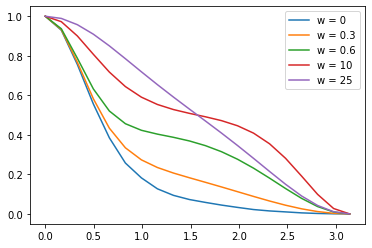

In [39]:
ks = np.linspace(0, np.pi, 20)
tau = 1
for w in [0, 0.3, 0.6, 10, 25]:
    pks = calk_noisy_pk(ks, tau, w)
    plt.plot(ks,pks, label=f'w = {w}')
plt.legend()
plt.show()

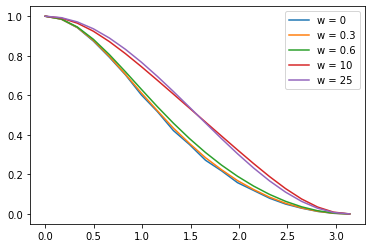

In [40]:
ks = np.linspace(0, np.pi, 20)
tau = 0.1
for w in [0, 0.3, 0.6, 10, 25]:
    pks = calk_noisy_pk(ks, tau, w)
    plt.plot(ks,pks, label=f'w = {w}')
plt.legend()
plt.show()

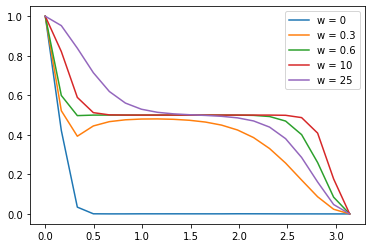

In [41]:
ks = np.linspace(0, np.pi, 20)
tau = 10
for w in [0, 0.3, 0.6, 10, 25]:
    pks = calk_noisy_pk(ks, tau, w)
    plt.plot(ks,pks, label=f'w = {w}')
plt.legend()
plt.show()

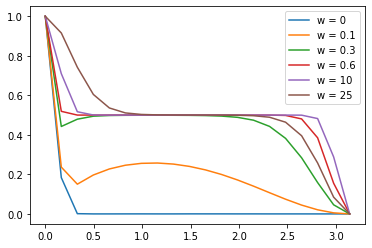

In [42]:
ks = np.linspace(0, np.pi, 20)
tau = 20
for w in [0, 0.1,0.3, 0.6, 10, 25]:
    pks = calk_noisy_pk(ks, tau, w)
    plt.plot(ks,pks, label=f'w = {w}')
plt.legend()
plt.show()

In [3]:
def calc_noisy_data(Ns, taus, noises):
    processes = []
    lock = Lock()
    for N, tau, noise in [(N, tau, noise) for N in Ns for tau in taus for noise in noises]:
        p = Process(target=calc_noisy_data_single, args=(N, tau, lock, noise))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        

def calc_noisy_data_single(N, tau, lock, w):
    os.nice(1)
    tau = round(tau, 6)

    # Load data from file if it exists, or create an empty DataFrame
    try:
        df = pd.read_csv('data.csv')
        df = df.sort_values(['N', 'tau'])
    except FileNotFoundError:
        df = pd.DataFrame(columns=['N', 'tau', 'type', 'noise','probability', 'mean', 
                                'second_moment', 'third_moment', 'fourth_moment',
                                'variance', 'skewness', 'kurtosis'])

    # Check if data[N][tau] is in DataFrame
    if not df.empty and not df[(df['N'] == N) & (df['tau'] == tau) & (df['noise'] == w)].empty:
        pass


    # Calculate and save to file
    else:
        # Calculate probabilities
        ks = k_f(np.arange(0, N/2), N)
        pks_numric = calk_noisy_pk(ks, tau, w)
        d_vals = np.arange(0,N+1,2)
        
        num_probability_mass_function = calc_kink_probabilities(pks_numric, d_vals)
        num_probability_mass_function = np.where(num_probability_mass_function < epsilon, 0, num_probability_mass_function)
        num_mask = (np.roll(num_probability_mass_function, 0) == 0) & (np.roll(num_probability_mass_function, -2) == 0)
        num_mask[-1] = False
        num_mask[-2] = False
        num_probability_mass_function[np.roll(num_mask, 1)] = 0

        # Calculate cumulants
        num_cumulants = calculate_cumulants(num_probability_mass_function, d_vals)

        # Prepare data for DataFrame
        pk_data_df = pd.DataFrame({'probability': [pks_numric.tolist()], 'N': [N], 'tau': [tau], 'type': ['pk'], 'noise': [w]})
        num_data_df = pd.DataFrame({**num_cumulants, 'probability': [num_probability_mass_function.tolist()], 'N': [N], 'tau': [tau], 'type': ['numeric'], 'noise': [w]})

        
        with lock:
        # Load data from file if it exists, or create an empty DataFrame
            try:
                df = pd.read_csv('data.csv')
                df = df.sort_values(['N', 'tau', 'noise'])
            except FileNotFoundError:
                df = pd.DataFrame(columns=['N', 'tau', 'type', 'noise', 'probability', 'mean', 
                                        'second_moment', 'third_moment', 'fourth_moment',
                                        'variance', 'skewness', 'kurtosis'])
            # Concatenate the DataFrames
            df = pd.concat([df, pk_data_df, num_data_df])
            df.to_csv('data.csv', index=False)

## Calc data

In [4]:
taus = [i for i in np.logspace(-4, -3, 4)]
for i in np.logspace(3, 4, 4):
    taus.append(i)
data = calc_data([50,100], taus)

: 

: 

In [8]:
import pandas as pd

def get_unique_tau_and_N(file_path):
    # Read the DataFrame from the file
    df = pd.read_csv(file_path)

    # Get the 'tau' and 'N' columns as sets
    tau_set = set(df['tau'].tolist())
    N_set = set(df['N'].tolist())

    return tau_set, N_set

# Use the function
tau_set, N_set = get_unique_tau_and_N('data.csv')

# Print the sets
print('Unique tau:', tau_set)
print('Unique N:', N_set)


Unique tau: {0.188739, 0.30392, 0.48939, 0.788046, 1.268961, 2.04336, 3.290345, 5.298317, 8.531679, 385.662042, 13.738238, 148.735211, 22.122163, 0.0001, 0.028072, 0.11721, 35.622479, 0.004175, 0.000316, 0.006723, 0.017433, 57.361525, 0.07279, 0.000215, 0.045204, 0.000464, 92.367086, 0.002593, 1000.0, 621.016942, 239.502662, 0.000562, 0.010826, 0.001, 0.00161}
Unique N: {50, 100}


In [9]:
data = calc_noisy_data(N_set, tau_set, [0.001,0.01,0.05,0.2])

Process Process-520:
Process Process-513:
Process Process-512:
Process Process-508:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-3-09feaccbb2b5>"

## Sort

C:\Users\USER\AppData\Local\Temp\ipykernel_23856\3466717884.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['ratio'] = clean_data['variance'] / clean_data['mean']


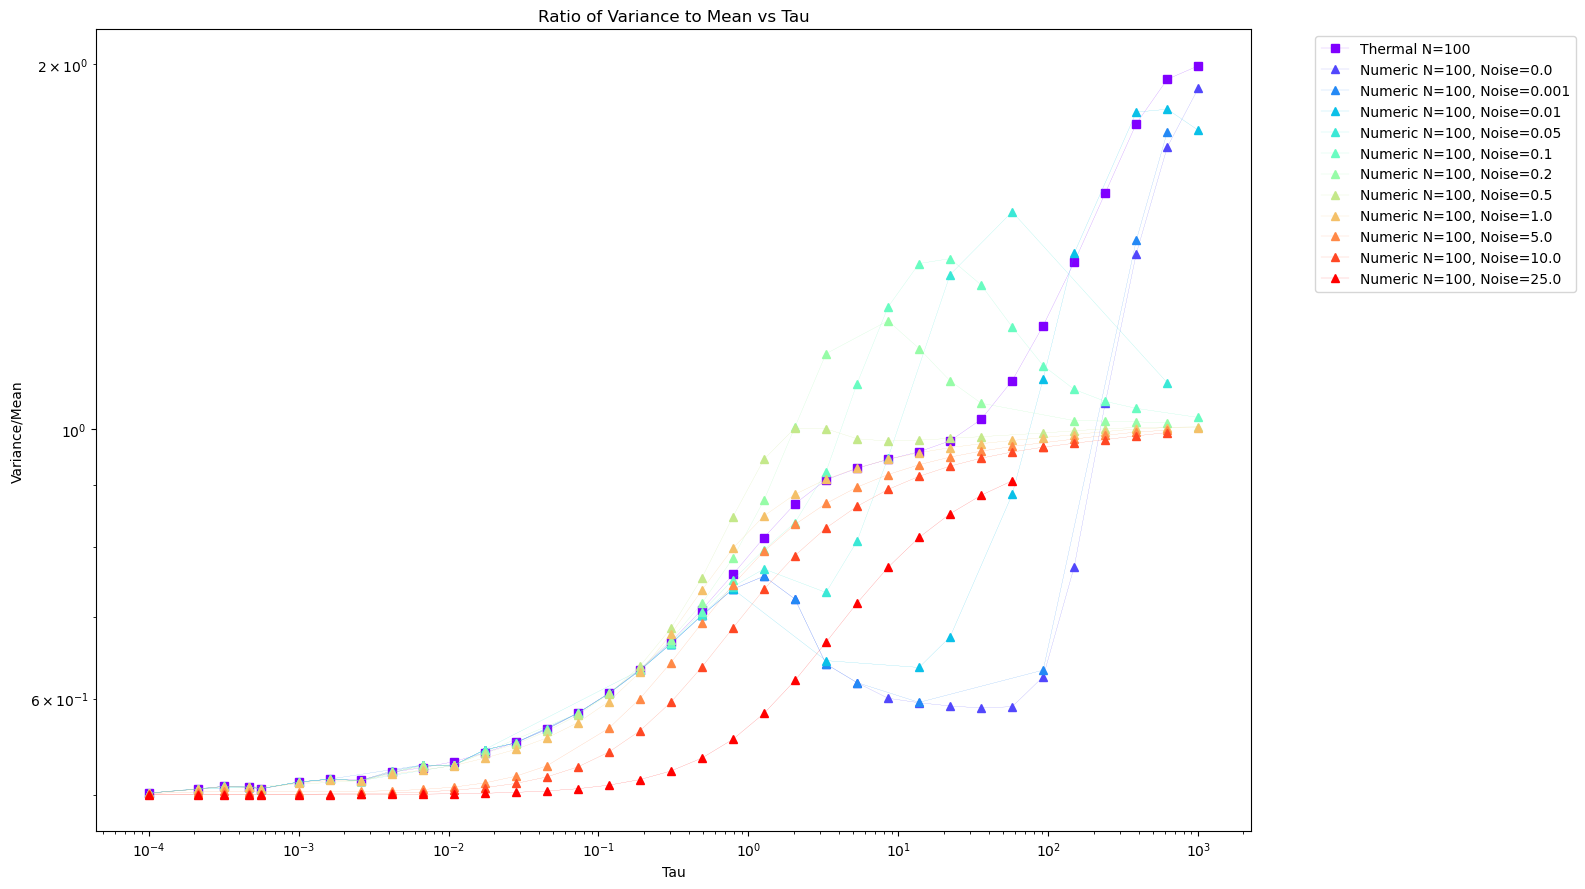

In [14]:
# Load the data from the CSV file
data = pd.read_csv('data.csv')

# Remove rows with NaN values in either the 'mean' or 'variance' column
clean_data = data.dropna(subset=['mean', 'variance'])

# Calculate the ratio of variance to mean
clean_data['ratio'] = clean_data['variance'] / clean_data['mean']

def plot_cumulant21_ratio(N, tau_min, tau_max, save=False, log=True):
    plt.figure(figsize=(16, 9))

    # Get unique noise levels
    noise_levels = clean_data['noise'].unique()

    colors = cm.rainbow(np.linspace(0, 1, len(noise_levels) + 1))

    # Get the data in the tau range for the current N
    data = clean_data[(clean_data['N'] == N) & (clean_data['tau'] >= tau_min) & (clean_data['tau'] <= tau_max)]
    
    # Split the data into thermal
    therm_data = data[data['type'] == 'thermal']

    # Calculate the ratio of the second cumulant to the first (variance/mean) for thermal data
    therm_ratio = therm_data['variance'] / therm_data['mean']

    # Plot thermal data
    plt.plot(therm_data['tau'], therm_ratio, color=colors[0], label=f'Thermal N={N}', marker='s', linewidth=0.1, markersize=6)

    # Iterate over noise levels for Numeric data
    for idy, noise in enumerate(noise_levels):
        # Get the data in the tau range for the current N and noise
        num_data = data[(data['type'] == 'numeric') & (data['noise'] == noise)]

        # Calculate the ratio of the second cumulant to the first (variance/mean) for numeric data
        num_ratio = num_data['variance'] / num_data['mean']

        # Plot numeric data with different colors and labels
        plt.plot(num_data['tau'], num_ratio, color=colors[idy+1], label=f'Numeric N={N}, Noise={noise}', marker='^', linewidth=0.1, markersize=6)

    # Set labels, title, and legend
    plt.xlabel('Tau')
    plt.ylabel('Variance/Mean')
    plt.title('Ratio of Variance to Mean vs Tau')

    # Place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xscale('log')
    if log:
        plt.yscale('log')

    # Display the plot
    plt.tight_layout()
    if save:
        plt.savefig(f'variance_mean_ratio_N_{N}.svg')
    plt.show()

# Call the function with the specified parameters, the full range of Tau, and save=True
tau_min = clean_data['tau'].min()
tau_max = clean_data['tau'].max()
plot_cumulant21_ratio(100, tau_min, tau_max)

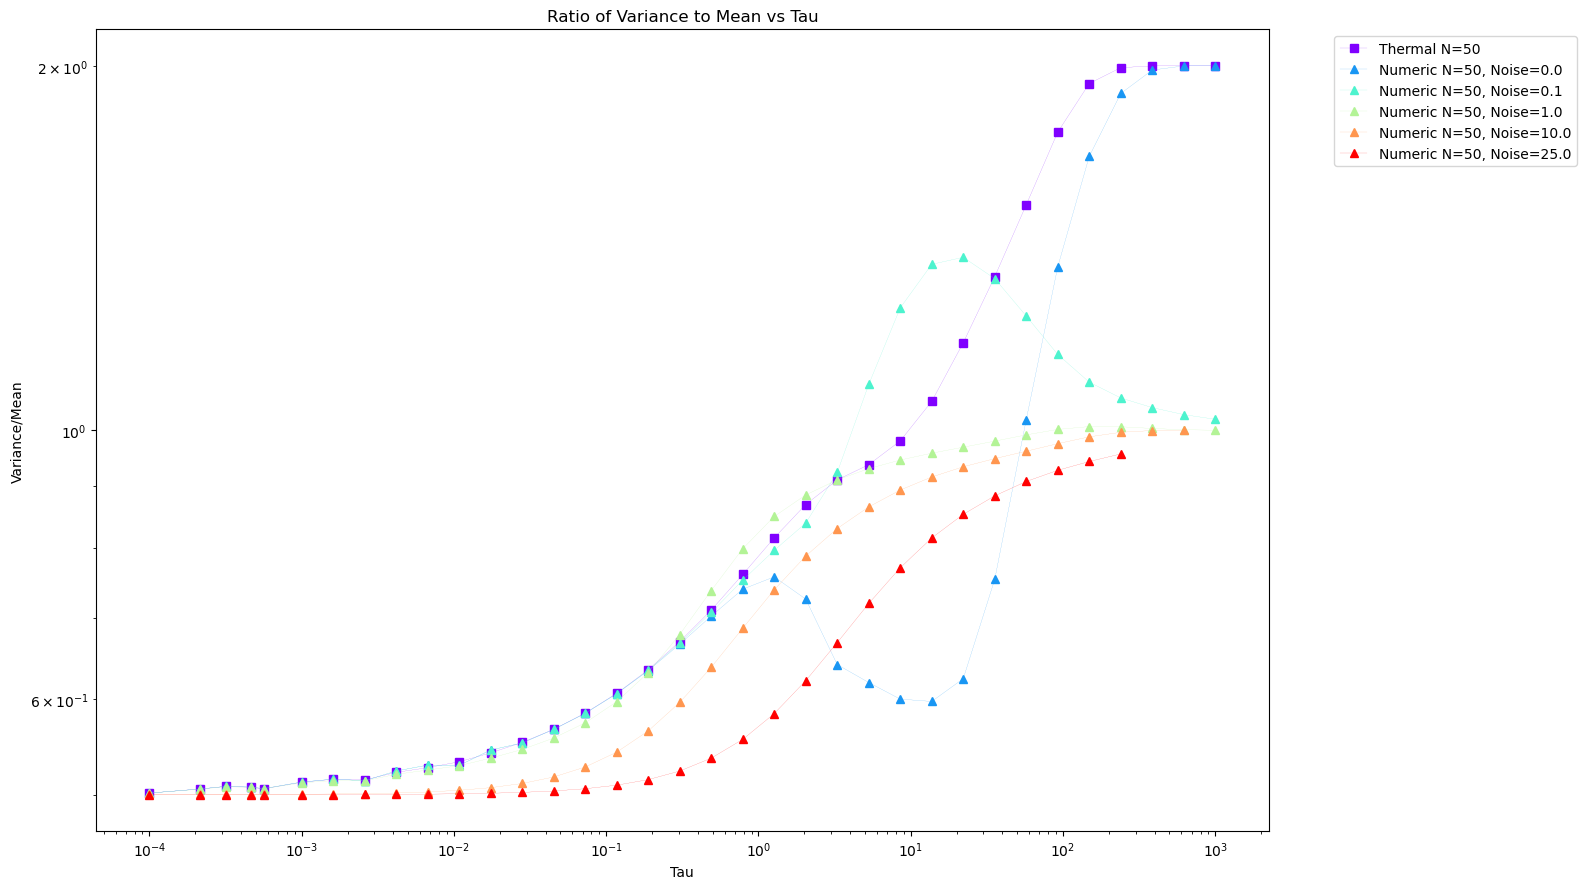

In [7]:
plot_cumulant21_ratio(50, tau_min, tau_max)

C:\Users\USER\AppData\Local\Temp\ipykernel_23856\3746888633.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['ratio'] = clean_data['variance'] / clean_data['mean']


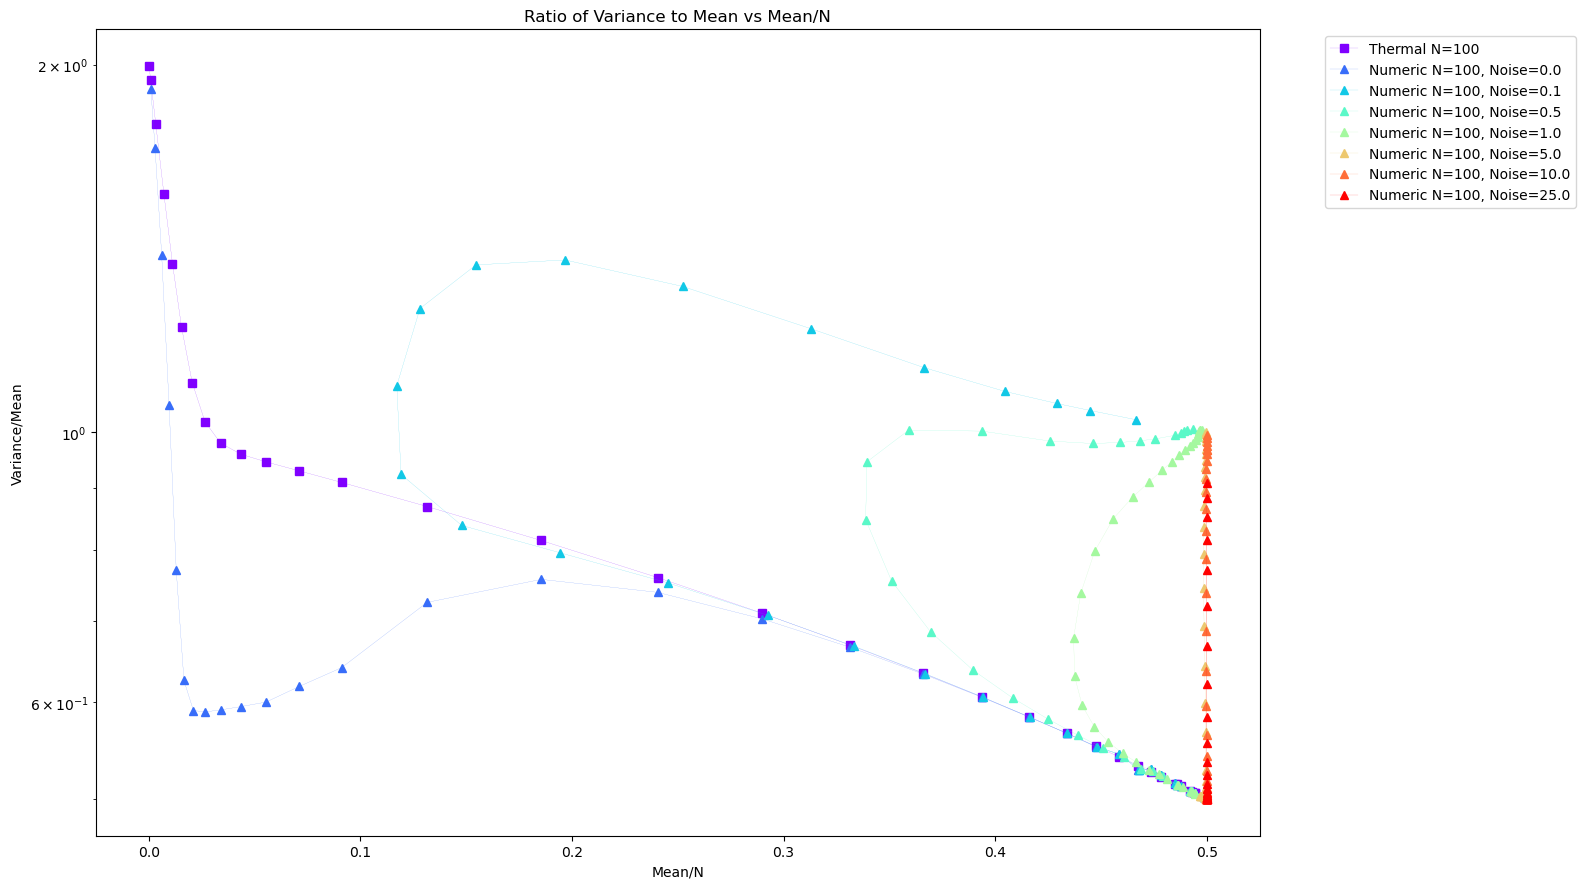

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Load the data from the CSV file
data = pd.read_csv('data.csv')

# Remove rows with NaN values in either the 'mean' or 'variance' column
clean_data = data.dropna(subset=['mean', 'variance'])

# Calculate the ratio of variance to mean
clean_data['ratio'] = clean_data['variance'] / clean_data['mean']

def plot_cumulant21_ratio_mean(N, save=False, log=True):
    plt.figure(figsize=(16, 9))

    # Get unique noise levels
    noise_levels = clean_data['noise'].unique()

    colors = cm.rainbow(np.linspace(0, 1, len(noise_levels) + 1))

    # Get the data for the current N
    data = clean_data[(clean_data['N'] == N)]
    
    # Split the data into thermal
    therm_data = data[data['type'] == 'thermal']

    # Calculate the ratio of the second cumulant to the first (variance/mean) for thermal data
    therm_ratio = therm_data['variance'] / therm_data['mean']

    # Plot thermal data
    plt.plot(therm_data['mean']/N, therm_ratio, color=colors[0], label=f'Thermal N={N}', marker='s', linewidth=0.1, markersize=6)

    # Iterate over noise levels for Numeric data
    for idy, noise in enumerate(noise_levels):
        # Get the data for the current N and noise
        num_data = data[(data['type'] == 'numeric') & (data['noise'] == noise)]

        # Calculate the ratio of the second cumulant to the first (variance/mean) for numeric data
        num_ratio = num_data['variance'] / num_data['mean']

        # Plot numeric data with different colors and labels
        plt.plot(num_data['mean']/N, num_ratio, color=colors[idy+1], label=f'Numeric N={N}, Noise={noise}', marker='^', linewidth=0.1, markersize=6)

    # Set labels, title, and legend
    plt.xlabel('Mean/N')
    plt.ylabel('Variance/Mean')
    plt.title('Ratio of Variance to Mean vs Mean/N')

    # Place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    #plt.xscale('log')
    if log:
        plt.yscale('log')

    # Display the plot
    plt.tight_layout()
    if save:
        plt.savefig(f'variance_mean_ratio_N_{N}.svg')
    plt.show()

# Call the function with the specified parameters, and save=True
plot_cumulant21_ratio_mean(100, save=True)

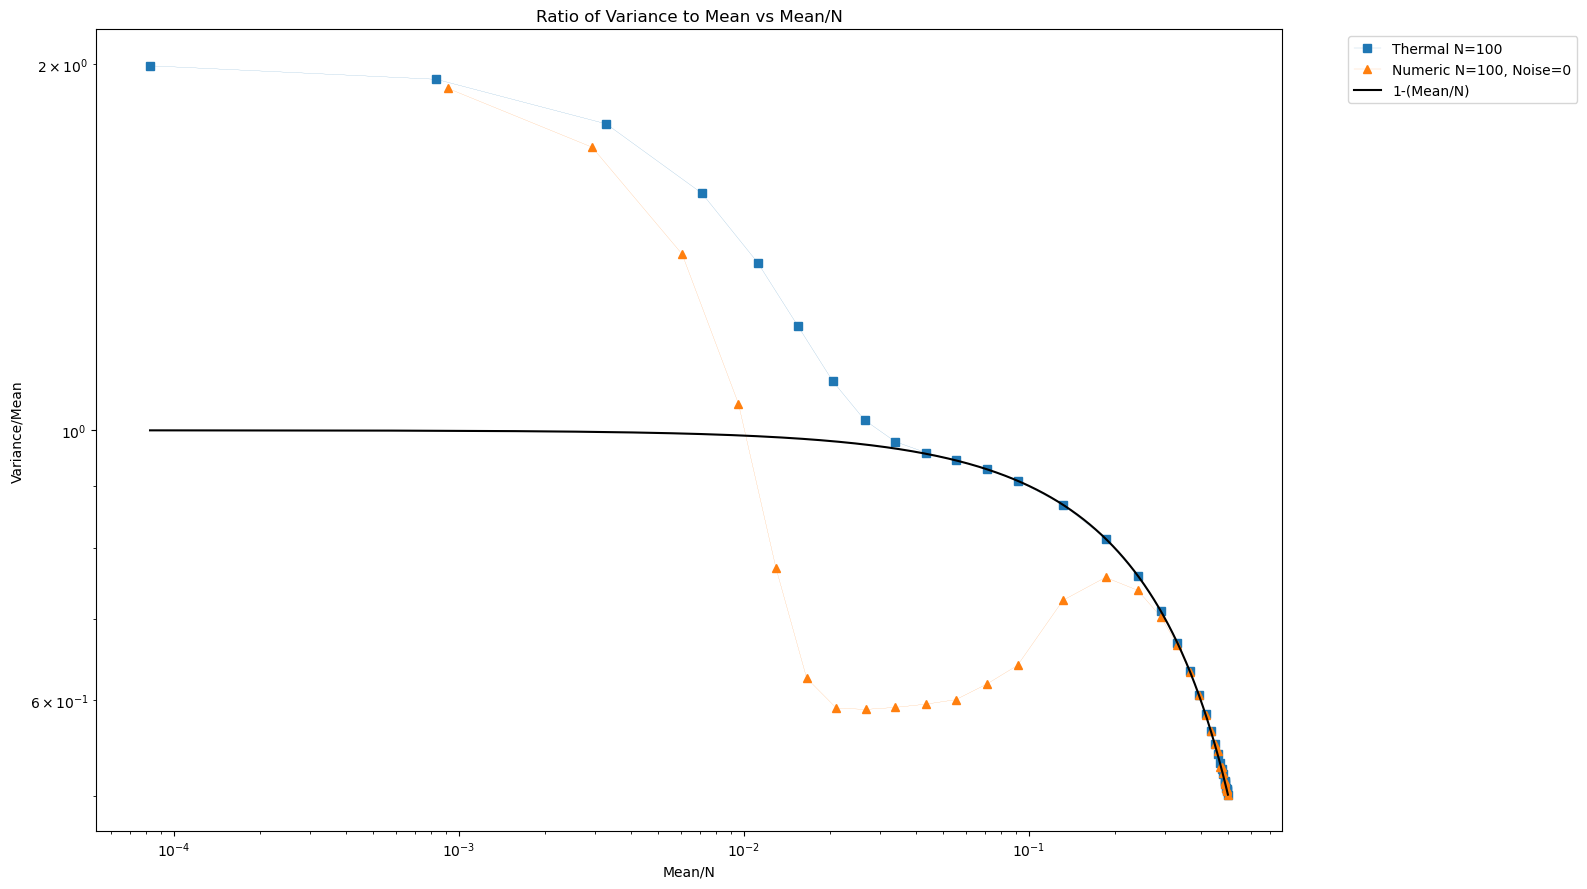

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the CSV file
data = pd.read_csv('data.csv')

# Filter out rows with NaN values in either the 'mean' or 'variance' column
clean_data = data.dropna(subset=['mean', 'variance'])

def plot_cumulant21_ratio_mean(N, noise, save=False, log=True):
    plt.figure(figsize=(16, 9))

    # Get the data for the current N
    data = clean_data[(clean_data['N'] == N)]
    
    # Split the data into thermal
    therm_data = data[data['type'] == 'thermal']

    # Calculate the ratio of the second cumulant to the first (variance/mean) for thermal data
    therm_ratio = therm_data['variance'] / therm_data['mean']

    # Plot thermal data
    plt.plot(therm_data['mean']/N, therm_ratio, label=f'Thermal N={N}', marker='s', linewidth=0.1, markersize=6)

    # Get the data for the current N and noise
    num_data = data[(data['type'] == 'numeric') & (data['noise'] == noise)]

    # Calculate the ratio of the second cumulant to the first (variance/mean) for numeric data
    num_ratio = num_data['variance'] / num_data['mean']

    # Plot numeric data
    plt.plot(num_data['mean']/N, num_ratio, label=f'Numeric N={N}, Noise={noise}', marker='^', linewidth=0.1, markersize=6)

    # Add line 1-(mean/N)
    x_values = np.linspace(min(therm_data['mean']/N), max(therm_data['mean']/N), num=1000)
    y_values = 1 - x_values
    plt.plot(x_values, y_values, label='1-(Mean/N)', color='black')

    # Set labels, title, and legend
    plt.xlabel('Mean/N')
    plt.ylabel('Variance/Mean')
    plt.title('Ratio of Variance to Mean vs Mean/N')

    # Place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.xscale('log')
    if log:
        plt.yscale('log')

    # Display the plot
    plt.tight_layout()
    if save:
        plt.savefig(f'variance_mean_ratio_N_{N}.svg')
    plt.show()

# Call the function with the specified parameters
plot_cumulant21_ratio_mean(100, 0, save=False)


In [ ]:
# The 'test' object should have the 't' and 'y' attributes since it's a result of 'solve_ivp'.
time = test.t
psi_0 = test.y[0, :]
psi_1 = test.y[1, :]

# Normalize 'time' to the range [0, 1] for the colormap.
time_normalized = (time - np.min(time)) / (np.max(time) - np.min(time))

# Create a new figure for the first plot.
plt.figure()

# Plot the real and imaginary parts of psi_0, with the color indicating the time.
plt.scatter(psi_0.real, psi_0.imag, c=time_normalized, cmap='viridis', marker='o', edgecolors='r')

# Add labels and a colorbar.
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Time evolution of psi[0]')
plt.colorbar(label='Time')

# Create a new figure for the second plot.
plt.figure()

# Plot the real and imaginary parts of psi_1, with the color indicating the time.
plt.scatter(psi_1.real, psi_1.imag, c=time_normalized, cmap='viridis', marker='o', edgecolors='r')

# Add labels and a colorbar.
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Time evolution of psi[1]')
plt.colorbar(label='Time')

# Show the plots.
plt.show()

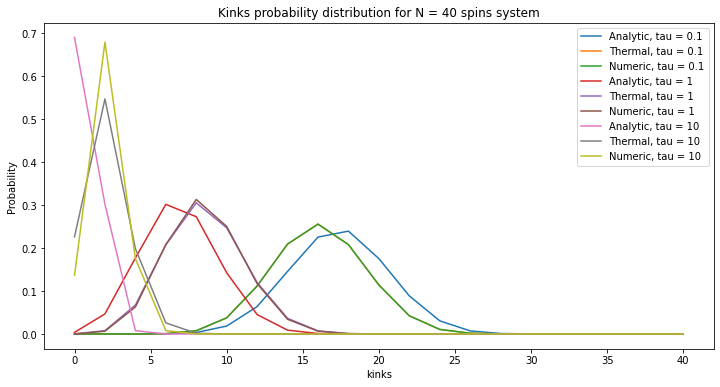

In [151]:
plot_probabilities(40, [0.1,1,10], range=None, save=False)

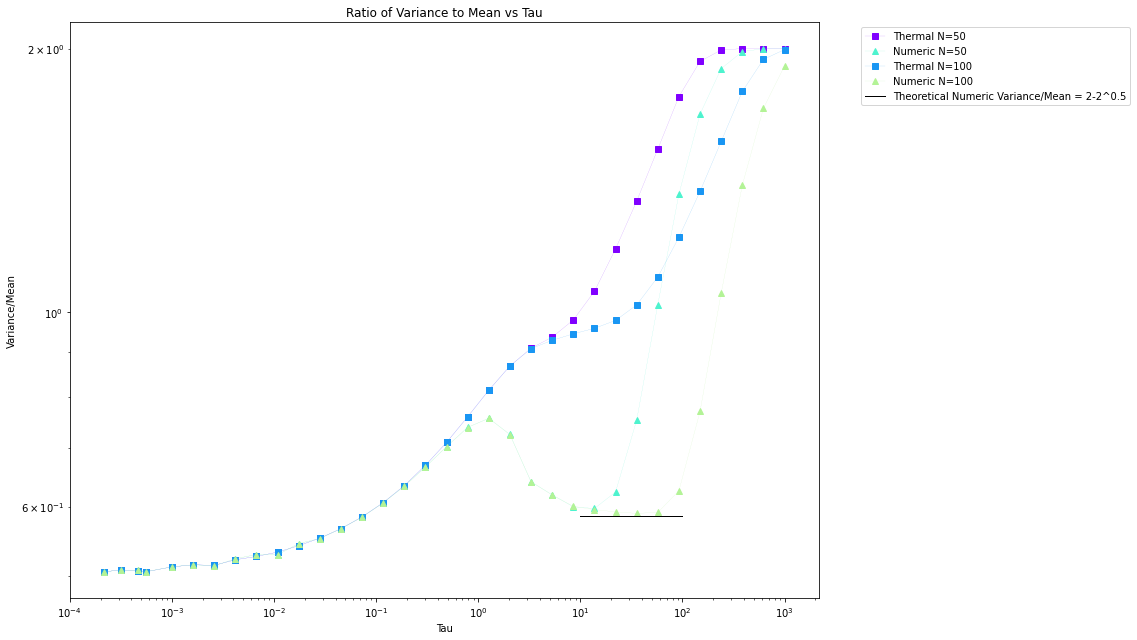

In [4]:
plot_cumulant21_ratio([50,100], 10**-4, 10**4)

Time evolving:   0%|          | 0/10000000 [00:00<?, ?it/s]

Time evolving: 100%|██████████| 10000000/10000000 [00:52<00:00, 191885.45it/s]


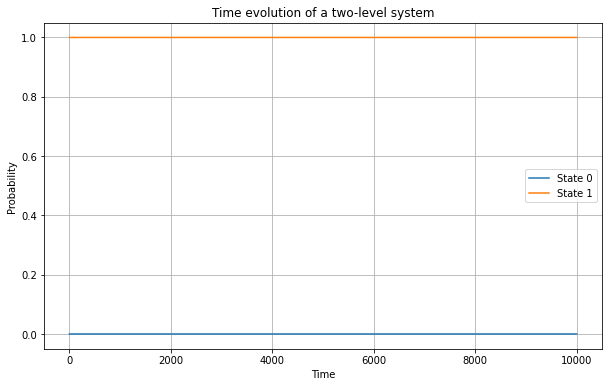

0.9999999999999998


In [343]:
tau = 1000    # in natural units
t_max = 10*tau # total simulation time
dt = tau*(10**-6)  # time step

k = np.pi
psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
plot_time_ev(psi_t, t_max)
psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
print(np.sum(np.abs(psi)**2))

In [344]:
print((np.abs(psi_t[-1])**2))
print(np.sum(np.abs(psi_t[-1])**2))

[4.35582341e-33 9.99999961e-01]
0.9999999613352922


Time evolving: 100%|██████████| 10000000/10000000 [00:51<00:00, 192716.89it/s]


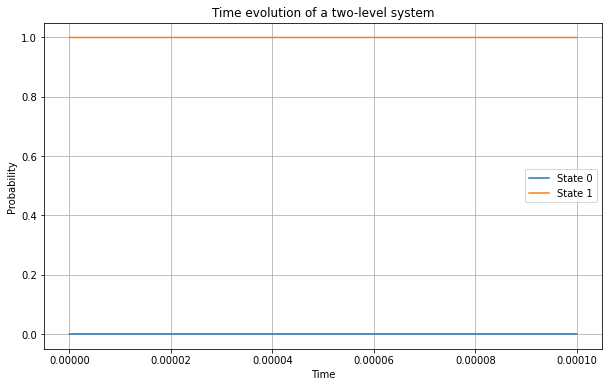

1.0000000000000002


In [347]:
tau = 0.00001    # in natural units
t_max = 10*tau # total simulation time
dt = tau*(10**-6)  # time step

k = 0.1
psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
plot_time_ev(psi_t, t_max)
psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
print(np.sum(np.abs(psi)**2))

In [349]:
print(np.sum(np.abs(psi_t[-1])**2))


0.9999999999933765


Time evolving:   0%|          | 0/5000000 [00:00<?, ?it/s]

Time evolving: 100%|██████████| 5000000/5000000 [00:24<00:00, 201413.56it/s]


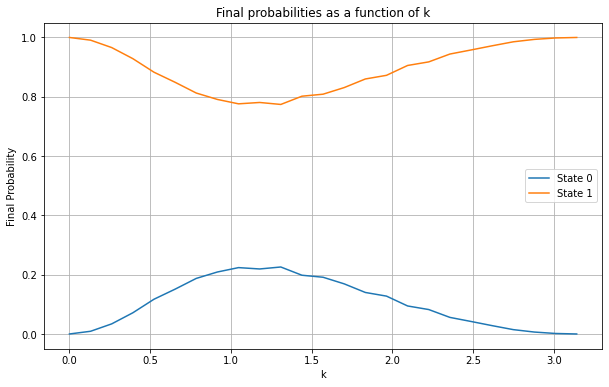

In [225]:
tau = 0.3    # in natural units
t_max = 50*tau # total simulation time
dt = tau*(10**-5)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
plot_states_k(t_max, dt, psi0, tau)

In [350]:
tau = 10000    # in natural units
t_max = 10*tau # total simulation time
dt = tau*(10**-6)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
final_probabilities = []
k_values = np.linspace(0, np.pi, 20)

for k in k_values:
    psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
    psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
    # Calculate the absolute squares of the components for the final time step
    S = np.array([np.sin(k/2), np.cos(k/2)])
    final_probabilities.append(np.abs(np.dot(S,psi))**2)

t10000 = np.array(final_probabilities)

Time evolving:   0%|          | 0/10000000 [00:00<?, ?it/s]

Time evolving: 100%|██████████| 10000000/10000000 [00:53<00:00, 186648.00it/s]


In [13]:
tau = 10000    # in natural units
t_max = 10*tau # total simulation time
dt = tau*(10**-6)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
final_probabilities = []
k_values = np.linspace(0, 0.03, 30)


for k in k_values:
    psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
    psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
    # Calculate the absolute squares of the components for the final time step
    S = np.array([np.sin(k/2), np.cos(k/2)])
    final_probabilities.append(np.abs(np.dot(S,psi))**2)

temp = np.array(final_probabilities)

Time evolving:   2%|▏         | 211192/10000000 [08:36<6:39:22, 408.51it/s] 


KeyboardInterrupt: 

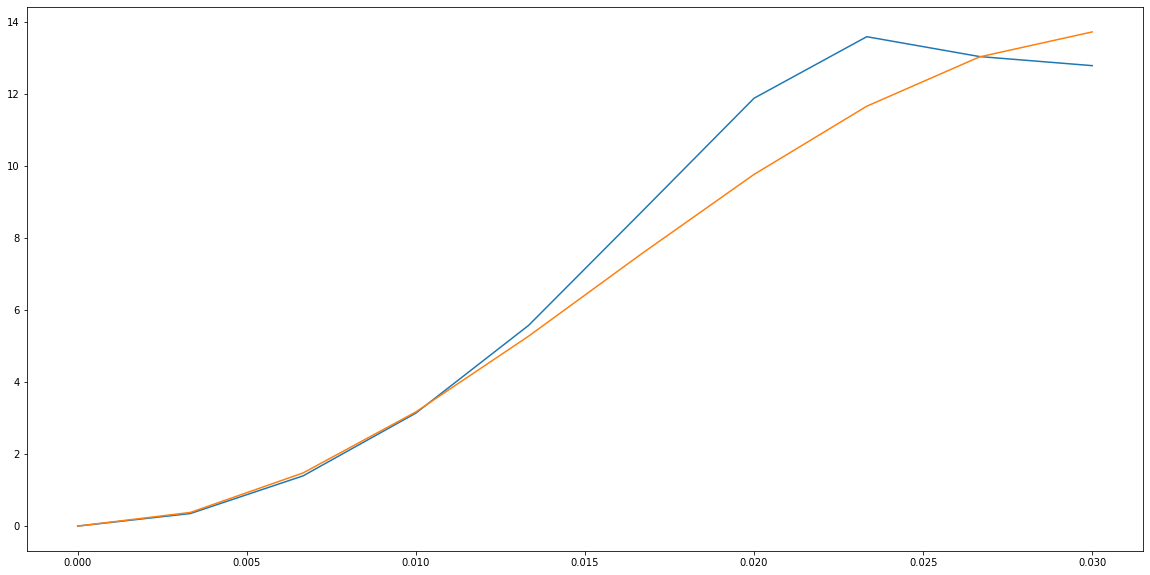

In [387]:

plt.figure(figsize=(20,10))
plt.plot(k_values, f(k_values,temp), label="data")
plt.plot(k_values, 13.8*np.sin(k_values*50)**2, label="f(k) approx")

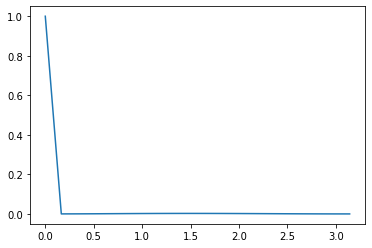

In [352]:
plt.plot(k_values, t10000, label="f(k)")

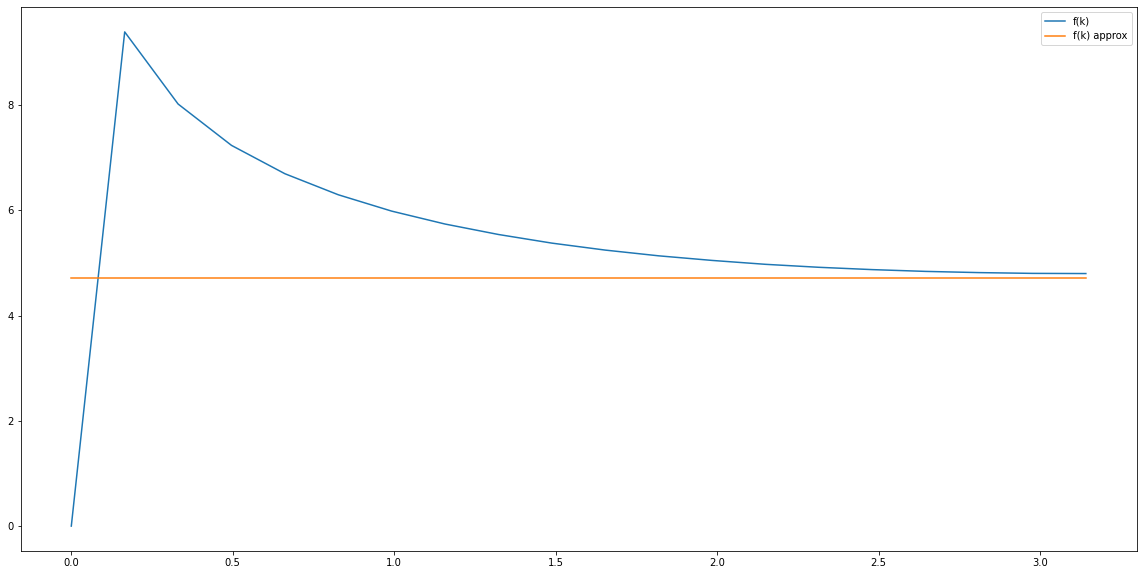

In [358]:
def f(ks, ps):
    result = []
    for i in range(len(ks)):
        result.append(-np.log(ps[i]/(np.cos(ks[i]/2)**2)))
    return result

plt.figure(figsize=(20,10))
plt.plot(k_values, f(k_values,t10000), label="f(k)")
plt.plot(k_values, [np.pi*1.5 for _ in k_values], label="f(k) approx")
plt.legend()


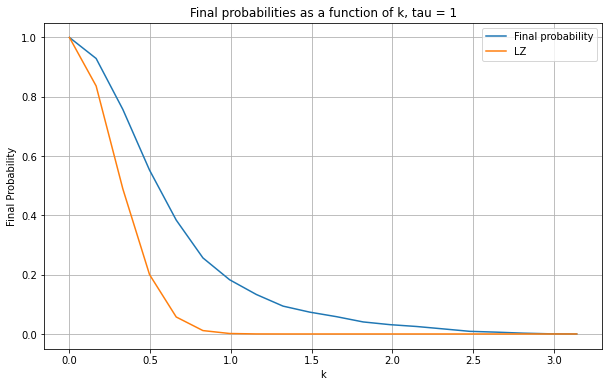

In [300]:
a=2*np.pi
b=1
c=2

def pk(k, tau):
    return np.exp(-a*(tau**b)*((k)**c))*(np.cos(k/2)**2)

# Plot the final probabilities for each state as a function of k
plt.figure(figsize=(10,6))
plt.plot(k_values, t1, label="Final probability")
plt.plot(k_values, pk(k_values, tau), label="LZ")
plt.legend()
plt.xlabel("k")
plt.ylabel("Final Probability")
plt.title("Final probabilities as a function of k, tau = " + str(tau))
plt.grid(True)
plt.show()

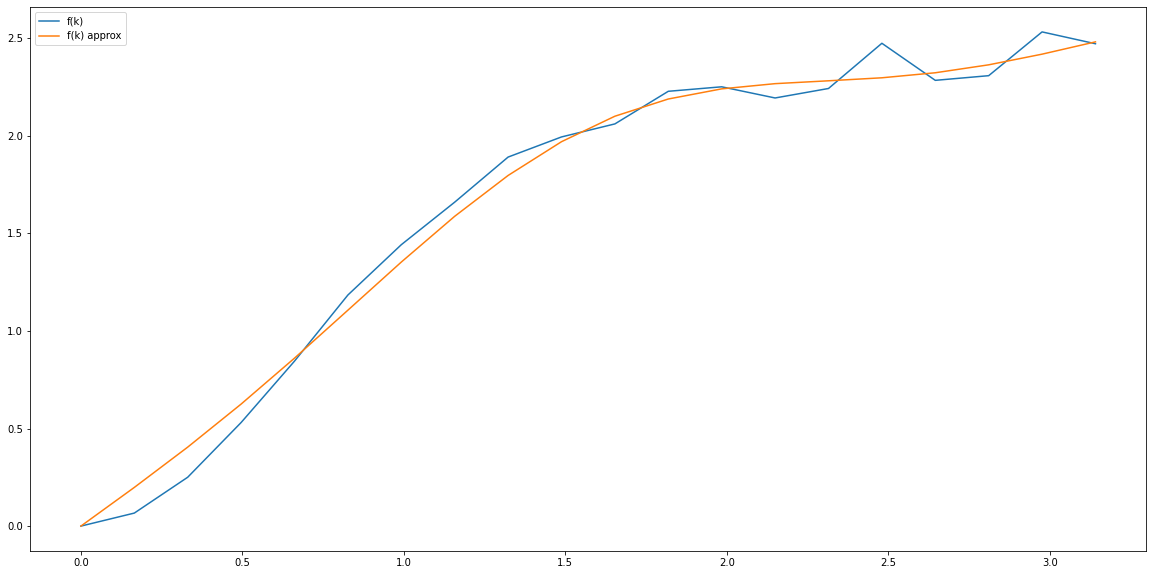

In [299]:
t1 = final_probabilities
def f(ks, ps):
    result = []
    for i in range(len(ks)):
        result.append(-np.log(ps[i]/(np.cos(ks[i]/2)**2)))
    return result

plt.figure(figsize=(20,10))
plt.plot(k_values, f(k_values,t1), label="f(k)")
plt.plot(k_values, (0.79*k_values+0.7*np.sin(k_values)-0.1*np.sin(3*k_values)), label="f(k) approx")
plt.legend()


In [301]:
tau = 10    # in natural units
t_max = 50*tau # total simulation time
dt = tau*(10**-5)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
final_probabilities = []
k_values = np.linspace(0, np.pi, 20)

for k in k_values:
    psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
    psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
    # Calculate the absolute squares of the components for the final time step
    S = np.array([np.sin(k/2), np.cos(k/2)])
    final_probabilities.append(np.abs(np.dot(S,psi))**2)

t10 = np.array(final_probabilities)

Time evolving: 100%|██████████| 5000000/5000000 [00:33<00:00, 147675.81it/s]


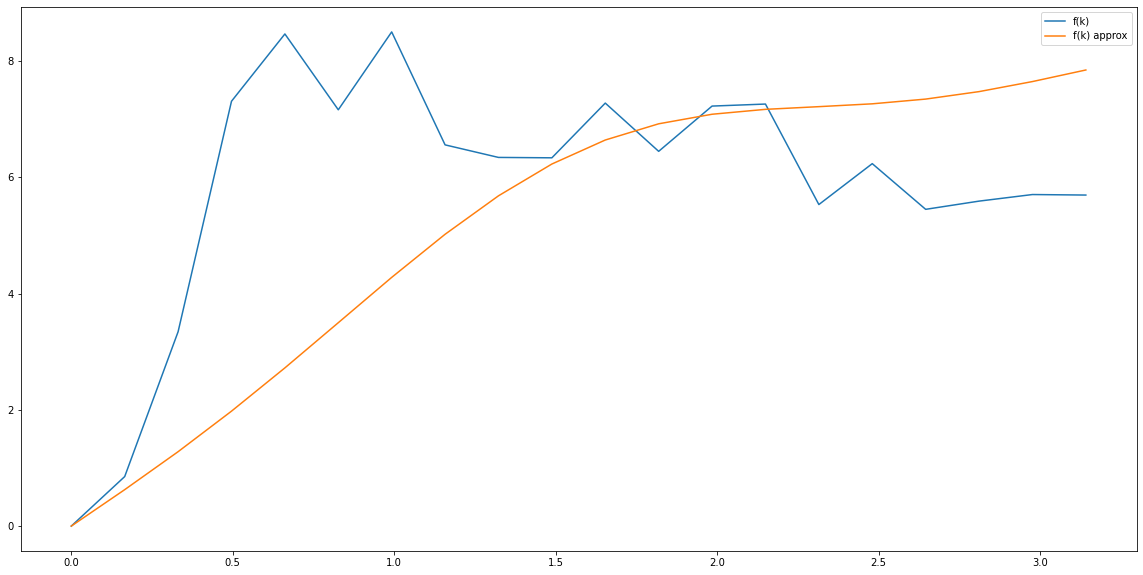

In [305]:
def f(ks, ps):
    result = []
    for i in range(len(ks)):
        result.append(-np.log(ps[i]/(np.cos(ks[i]/2)**2)))
    return result

plt.figure(figsize=(20,10))
plt.plot(k_values, f(k_values,t10), label="f(k)")
plt.plot(k_values, tau**0.5*(0.79*k_values+0.7*np.sin(k_values)-0.1*np.sin(3*k_values)), label="f(k) approx")
plt.legend()


In [307]:
tau = 100    # in natural units
t_max = 50*tau # total simulation time
dt = tau*(10**-5)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
final_probabilities = []
k_values = np.linspace(0, np.pi, 20)

for k in k_values:
    psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
    psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
    # Calculate the absolute squares of the components for the final time step
    S = np.array([np.sin(k/2), np.cos(k/2)])
    final_probabilities.append(np.abs(np.dot(S,psi))**2)

t100 = np.array(final_probabilities)

Time evolving: 100%|██████████| 5000000/5000000 [00:34<00:00, 144257.40it/s]


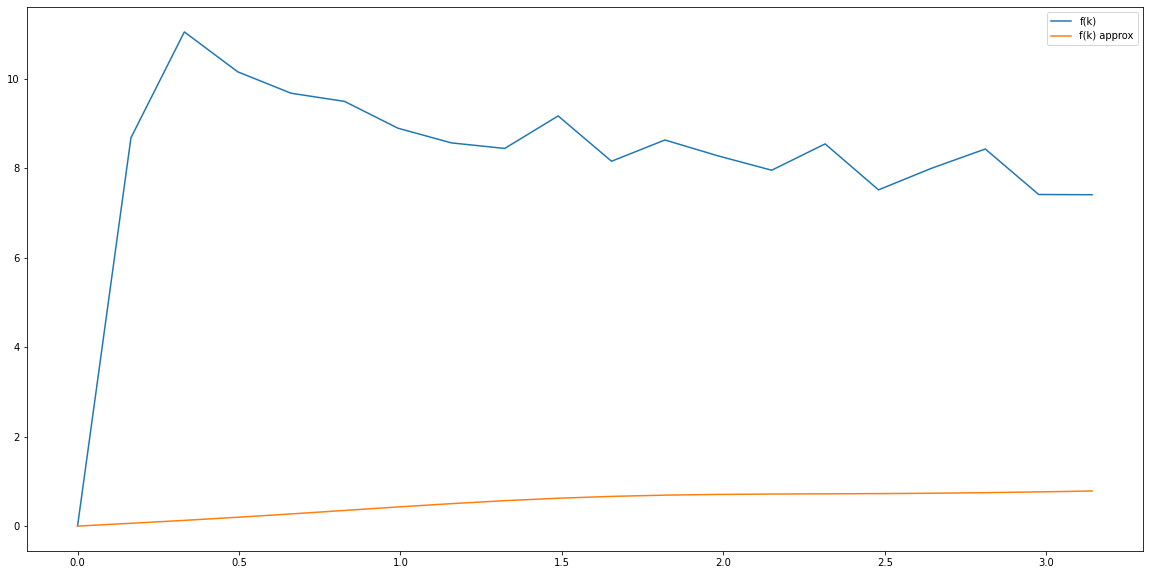

In [309]:
def f(ks, ps):
    result = []
    for i in range(len(ks)):
        result.append(-np.log(ps[i]/(np.cos(ks[i]/2)**2)))
    return result

plt.figure(figsize=(20,10))
plt.plot(k_values, f(k_values,t100), label="f(k)")
plt.plot(k_values, tau**0.5*(0.79*k_values+0.7*np.sin(k_values)-0.1*np.sin(3*k_values)), label="f(k) approx")
plt.legend()


In [308]:
tau = 0.1    # in natural units
t_max = 50*tau # total simulation time
dt = tau*(10**-5)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
final_probabilities = []
k_values = np.linspace(0, np.pi, 20)

for k in k_values:
    psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
    psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
    # Calculate the absolute squares of the components for the final time step
    S = np.array([np.sin(k/2), np.cos(k/2)])
    final_probabilities.append(np.abs(np.dot(S,psi))**2)

t01 = np.array(final_probabilities)

Time evolving: 100%|██████████| 4999999/4999999 [00:33<00:00, 148896.66it/s]


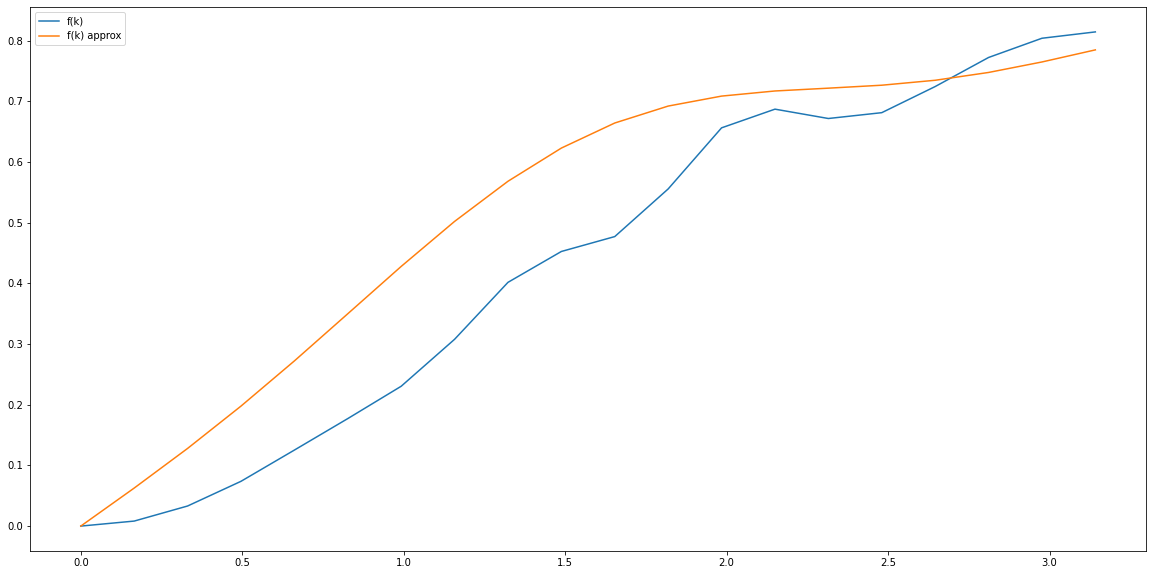

In [310]:
def f(ks, ps):
    result = []
    for i in range(len(ks)):
        result.append(-np.log(ps[i]/(np.cos(ks[i]/2)**2)))
    return result

plt.figure(figsize=(20,10))
plt.plot(k_values, f(k_values,t01), label="f(k)")
plt.plot(k_values, tau**0.5*(0.79*k_values+0.7*np.sin(k_values)-0.1*np.sin(3*k_values)), label="f(k) approx")
plt.legend()


In [311]:
tau = 0.0001    # in natural units
t_max = 50*tau # total simulation time
dt = tau*(10**-5)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
final_probabilities = []
k_values = np.linspace(0, np.pi, 20)

for k in k_values:
    psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
    psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
    # Calculate the absolute squares of the components for the final time step
    S = np.array([np.sin(k/2), np.cos(k/2)])
    final_probabilities.append(np.abs(np.dot(S,psi))**2)

t00001 = np.array(final_probabilities)

Time evolving: 100%|██████████| 5000000/5000000 [00:34<00:00, 144110.55it/s]


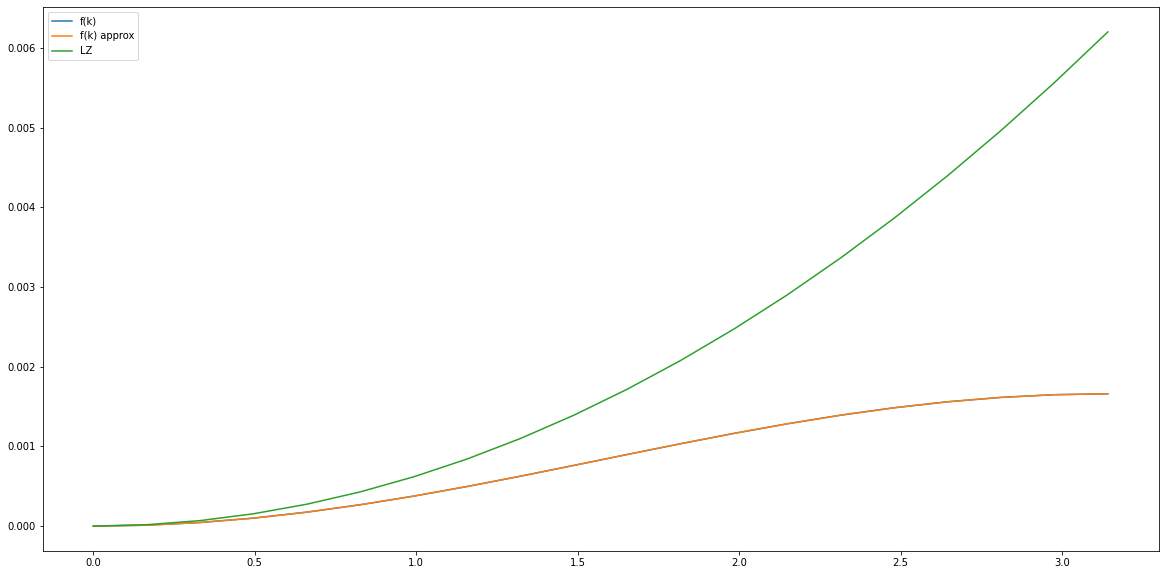

In [362]:
tau = 0.0001    # in natural units
t_max = 50*tau # total simulation time
dt = tau*(10**-5)  # time step
psi0 = np.array([0.0, 1.0], dtype=complex)
final_probabilities = []
k_values = np.linspace(0, np.pi, 20)

def f(ks, ps):
    result = []
    for i in range(len(ks)):
        result.append(-np.log(ps[i]/(np.cos(ks[i]/2)**2)))
    return result

plt.figure(figsize=(20,10))
plt.plot(k_values, f(k_values,t00001), label="f(k)")
plt.plot(k_values, 16.6*tau*np.sin(k_values/2)**2, label="f(k) approx")
plt.plot(k_values, 2*np.pi*tau*(k_values**2), label="LZ")
plt.legend()


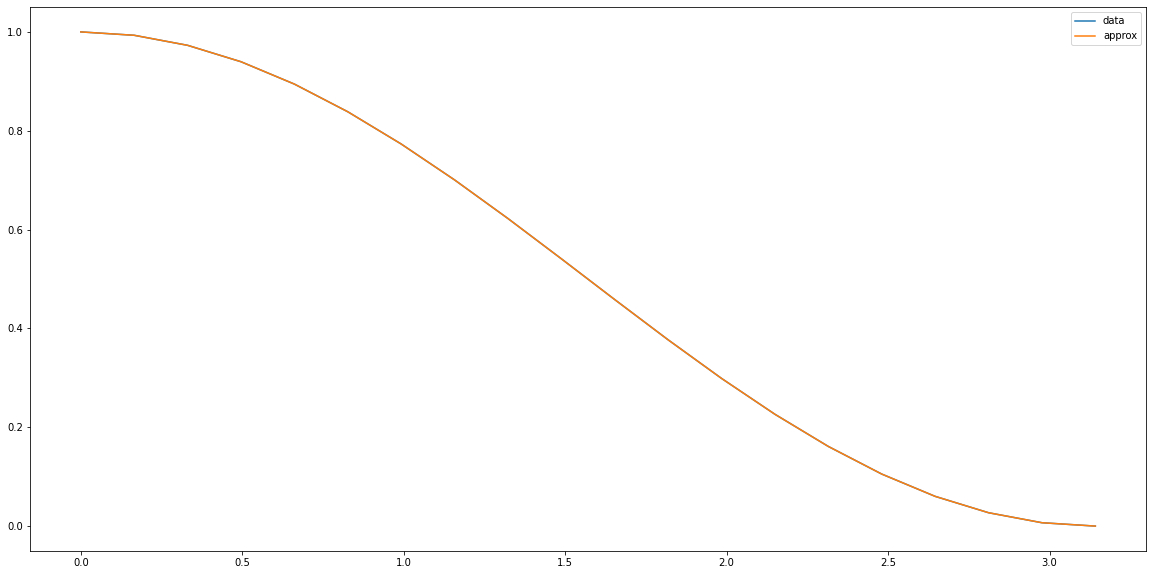

In [328]:
plt.figure(figsize=(20,10))
plt.plot(k_values, t00001, label="data")
plt.plot(k_values, [np.exp(-16.6*0.0001*np.sin(k/2)**2)*np.cos(k/2)**2 for k in k_values], label="approx")
plt.legend()

In [325]:
tau = 1000    # in natural units
t_max = 50*tau # total simulation time
dt = tau*(10**-5)  # time step
psi0 = np.array([0.0, 1.0])
final_probabilities = []
k_values = np.linspace(0, np.pi, 20)

for k in k_values:
    psi_t = time_ev_RK(t_max, dt, psi0, k, tau)
    psi = psi_t[-1]/np.linalg.norm(psi_t[-1])
    # Calculate the absolute squares of the components for the final time step
    S = np.array([np.sin(k/2), np.cos(k/2)])
    final_probabilities.append(np.abs(np.dot(S,psi))**2)

t10000 = np.array(final_probabilities)

Time evolving:   0%|          | 0/5000000 [00:00<?, ?it/s]

Time evolving: 100%|██████████| 5000000/5000000 [00:26<00:00, 186521.03it/s]
